# Extract Auto Club Group auto table 

Author: Mo Al Elew

**What notebook does/produces:**

Extracts territory rate setting tables from Auto Club filing PDFs and produces data files for analysis

**Issue/problem being solved:**

- Table is stored in a PDF

**Strategy to solve:**

General pattern:

1. Extract table data from PDF
2. Clean and process the data into a standardized format
3. Run any necessary caclulations to produce location effect figure
4. Match on geographic and demographic data
5. Determine nearest neighbor with lowest base rate

**Sources:**

- data.census.gov
- https://www2.census.gov/geo/tiger/TIGER2010/
- System for Electronic Rates and Forms Filing (SERFF)


In [1]:
import geopandas as gpd
import pandas as pd
import stringcase
import tabula

# Constants

In [2]:
TABLE_PDF_FP = (
    "./inputs/mi-auto-acgic-eff-11-1-23-territory-relativities-auto-club-cars.pdf"
)
BASE_RATE_TABLE = "./inputs/auto_base_rate_table.pdf"
TRACT_GIS_FP = "../01_demographics/outputs/tract_demographics_2020_2010.geojson"

DETROIT_TRACTS_FP = "./inputs/kx-city-of-detroit-michigan-census-tracts-2010-SHP.zip"
DETROIT_STREETS = (
    "./inputs/City_of_Detroit_Act51_Map_view_only_588694915804796340.geojson"
)

PROCESSED_EXPORT_FP = "./outputs/autoclub_auto.csv"
GIS_EXPORT_FP = "./outputs/autoclub_auto_gis.geojson"
RAW_EXPORT_FP = "./outputs/rate_table.csv"
CLEAN_EXPORT_FP = "./outputs/autoclub_auto_clean.csv"
CLEAN_MAP_EXPORT_FP = "./outputs/autoclub_auto_clean.geojson"

In [3]:
BASE_COLUMNS = [
    "company",
    "vehicle_type",
    "factor_circumvented",
    "factor_name",
    "geography_factor",
    "geography_type",
    "geography_factor_id",
    "latitude",
    "longitude",
    "county_fips",
    "tract_fips",
    "block_group_fips",
    "zip",
    "place_name_fips",
]

CLEAN_EXPORT_COLS = [
    "geo_id",
    "geo_name",
    "tot_pop",
    "white_pct",
    "black_pct",
    "white_tot",
    "black_tot",
    "generic_location_based_premium",
    "location_effect",
    "is_in_detroit",
]

In [4]:
COMPANY_NAME = "Auto Club"
VEHICLE_TYPE = "Auto"
FACTOR_CIRCUMVENTED = "zip"
FACTOR_NAME = "Base Rate"
GEOGRAPHY_FACTOR = "census_tract"
GEOGRAPHY_TYPE = "census_tract"

TRACT_GEO_ID_LEN = 11
UNCATEGORIZED_GEO_ID = "99999999999"
COUNTY_CODE_SUFFIX = "00000"

ROADS_TO_FILTER = ["8 Mile Rd"]
MILE_BUFFER = 3200  # 1600 meters in both directions

RATE_PREFIX = "rate_"

In [5]:
def get_rate_columns(df_rate_table):
    return [col for col in df_rate_table.columns if col.startswith(RATE_PREFIX)]


def get_avg_rate_factor(df_rate_table):
    rate_cols = get_rate_columns(df_rate_table)
    return df_rate_table[rate_cols].mean(axis=1)

# Read data

## Base rate table

I read in the base rate table and filter for regular vehicle base rates (which equals the base rates for utility and vans vehicles)

In [6]:
col2str = {"dtype": str}
kwargs = {"pandas_options": col2str}
BASERATE_TABLE_LIST = tabula.read_pdf(
    BASE_RATE_TABLE, pages="all", lattice=True, **kwargs
)

DF_BASE_RATE_TABLE = pd.concat(BASERATE_TABLE_LIST)
DF_BASE_RATE_TABLE = DF_BASE_RATE_TABLE.dropna(subset=["PPI"])
DF_BASE_RATE_TABLE = DF_BASE_RATE_TABLE.dropna(how="all", axis=1)
DF_BASE_RATE_TABLE = DF_BASE_RATE_TABLE.set_index("Vehicle Type")

assert DF_BASE_RATE_TABLE.loc["Regular"].equals(
    DF_BASE_RATE_TABLE.loc["Utility"]
) and DF_BASE_RATE_TABLE.loc["Regular"].equals(DF_BASE_RATE_TABLE.loc["Vans"])

base_rates = DF_BASE_RATE_TABLE.loc["Regular"]
base_rates = base_rates.str.replace(",", "").astype(float)
base_rates

BI          627.23
PD           23.78
MLPD         59.78
PPI         114.96
PIP_SL       22.42
PIP_MED    5460.92
PIP_WL      267.14
COMP        366.48
COLL       2031.43
UM           53.46
UIM          68.17
CR          195.74
DI            1.00
Name: Regular, dtype: float64

## Relativities table

In [7]:
TERRITORY_TABLES_LIST = tabula.read_pdf(
    TABLE_PDF_FP, pages="all", lattice=True, **kwargs
)
DF_TERRITORY_RELATIVES = pd.concat(TERRITORY_TABLES_LIST)

DF_TERRITORY_RELATIVES.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2816 entries, 0 to 11
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Census Tract  2816 non-null   object
 1   BI            2816 non-null   object
 2   PD            2816 non-null   object
 3   MLPD          2816 non-null   object
 4   PPI           2816 non-null   object
 5   PIP_MED       2816 non-null   object
 6   PIP_WL        2816 non-null   object
 7   COMP          2816 non-null   object
 8   COLL          2816 non-null   object
 9   CR            2816 non-null   object
 10  UM            2816 non-null   object
 11  UIM           2816 non-null   object
dtypes: object(12)
memory usage: 286.0+ KB


## Detroit 2010 tracts

In [8]:
DF_DETROIT_TRACTS = gpd.read_file(DETROIT_TRACTS_FP, dtype=str)
DF_DETROIT_TRACTS.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   aland_10    310 non-null    float64 
 1   awater_10   310 non-null    float64 
 2   countyfp_1  310 non-null    object  
 3   funcstat_1  310 non-null    object  
 4   geoid_10    310 non-null    object  
 5   intptlat_1  310 non-null    object  
 6   intptlon_1  310 non-null    object  
 7   mtfcc_10    310 non-null    object  
 8   name_10     310 non-null    object  
 9   namelsad_1  310 non-null    object  
 10  statefp_10  310 non-null    object  
 11  tractce_10  310 non-null    object  
 12  geometry    310 non-null    geometry
dtypes: float64(2), geometry(1), object(10)
memory usage: 31.6+ KB


## Tract demographics

In [9]:
gdf_tracts = gpd.read_file(TRACT_GIS_FP)
gdf_tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2813 entries, 0 to 2812
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   geo_id           2813 non-null   object  
 1   geo_name         2813 non-null   object  
 2   tot_pop_wt       2813 non-null   float64 
 3   white_tot_wt     2813 non-null   float64 
 4   black_tot_wt     2813 non-null   float64 
 5   aian_tot_wt      2813 non-null   float64 
 6   asian_tot_wt     2813 non-null   float64 
 7   nhopi_tot_wt     2813 non-null   float64 
 8   other_tot_wt     2813 non-null   float64 
 9   two_more_tot_wt  2813 non-null   float64 
 10  latin_tot_wt     2813 non-null   float64 
 11  white_pct_wt     2813 non-null   float64 
 12  black_pct_wt     2813 non-null   float64 
 13  aian_pct_wt      2813 non-null   float64 
 14  asian_pct_wt     2813 non-null   float64 
 15  nhopi_pct_wt     2813 non-null   float64 
 16  other_pct_wt     2813 non-null   f

# Calculate location-adjusted base rates

Auto Club Group assigns relativities for each territory. To calculate a a dollar figure total to each territory, I pull the regular vehicle base rate for each relevant coverage type from the base rate table. With the base rate, I multiply (COVERAGE BASE RATE * COVERAGE RELATIVITY_territory_) to estimate a base rate for each territory.

In [10]:
base_rates
df_base_rates = DF_TERRITORY_RELATIVES.set_index("Census Tract")
df_base_rates = df_base_rates.astype(float)
for col in df_base_rates.columns:
    df_base_rates[col] = df_base_rates[col] * base_rates[col]

df_base_rates = df_base_rates.reset_index()
df_base_rates

,Census Tract,BI,PD,MLPD,PPI,PIP_MED,PIP_WL,COMP,COLL,CR,UM,UIM
0,26001000100,359.277344,13.621184,34.241984,69.113952,3519.562940,142.439048,242.353224,985.649836,46.977600,27.852660,35.516570
1,26001970100,359.528236,13.630696,34.265896,69.113952,3526.116044,142.545904,242.353224,985.446693,46.977600,27.852660,35.516570
2,26001970400,359.528236,13.630696,34.265896,69.113952,3526.116044,142.545904,242.353224,985.446693,46.977600,27.852660,35.516570
3,26001970500,363.417062,13.778132,34.636532,69.757728,3546.321448,144.709738,242.939592,1002.104419,47.917152,28.130652,35.871054
4,26001970600,359.528236,13.630696,34.265896,69.113952,3526.116044,142.545904,242.353224,985.446693,46.977600,27.852660,35.516570
...,...,...,...,...,...,...,...,...,...,...,...,...
2811,26101990000,368.184010,13.958860,35.090860,69.113952,3611.306396,142.545904,242.353224,1058.375030,46.977600,27.852660,35.516570
2812,26029990000,464.840153,17.623358,44.302958,87.817944,3792.062848,181.281204,249.866064,1374.262395,60.053032,35.620398,45.421671
2813,26161421900,540.233199,20.481714,51.488514,78.345240,4078.215056,199.820720,291.644784,1418.547569,62.225746,40.902246,52.156867
2814,26161422900,594.802209,22.550574,56.689374,94.922472,4212.553688,206.125224,303.335496,1811.019845,78.256852,42.115788,53.704326


# Build processed table

In [11]:
df_processed_table = df_base_rates.copy()

## Rename columns

In [12]:
df_processed_table.columns = [
    col.lower().replace(" ", "_") for col in df_processed_table.columns
]
df_processed_table

,census_tract,bi,pd,mlpd,ppi,pip_med,pip_wl,comp,coll,cr,um,uim
0,26001000100,359.277344,13.621184,34.241984,69.113952,3519.562940,142.439048,242.353224,985.649836,46.977600,27.852660,35.516570
1,26001970100,359.528236,13.630696,34.265896,69.113952,3526.116044,142.545904,242.353224,985.446693,46.977600,27.852660,35.516570
2,26001970400,359.528236,13.630696,34.265896,69.113952,3526.116044,142.545904,242.353224,985.446693,46.977600,27.852660,35.516570
3,26001970500,363.417062,13.778132,34.636532,69.757728,3546.321448,144.709738,242.939592,1002.104419,47.917152,28.130652,35.871054
4,26001970600,359.528236,13.630696,34.265896,69.113952,3526.116044,142.545904,242.353224,985.446693,46.977600,27.852660,35.516570
...,...,...,...,...,...,...,...,...,...,...,...,...
2811,26101990000,368.184010,13.958860,35.090860,69.113952,3611.306396,142.545904,242.353224,1058.375030,46.977600,27.852660,35.516570
2812,26029990000,464.840153,17.623358,44.302958,87.817944,3792.062848,181.281204,249.866064,1374.262395,60.053032,35.620398,45.421671
2813,26161421900,540.233199,20.481714,51.488514,78.345240,4078.215056,199.820720,291.644784,1418.547569,62.225746,40.902246,52.156867
2814,26161422900,594.802209,22.550574,56.689374,94.922472,4212.553688,206.125224,303.335496,1811.019845,78.256852,42.115788,53.704326


In [13]:
def create_rate_label(col_name):
    return RATE_PREFIX + stringcase.snakecase(col_name.lower()).replace("___", "_")


def rename_rate_columns(df):
    rate_col_names = df.columns[1:]
    extracted_rate_col_names = [
        create_rate_label(col_name) for col_name in rate_col_names
    ]
    rate_col_renames = dict(zip(rate_col_names, extracted_rate_col_names))
    return df.rename(columns=rate_col_renames)


df_processed_table = rename_rate_columns(df_processed_table)
df_processed_table

,census_tract,rate_bi,rate_pd,rate_mlpd,rate_ppi,rate_pip_med,rate_pip_wl,rate_comp,rate_coll,rate_cr,rate_um,rate_uim
0,26001000100,359.277344,13.621184,34.241984,69.113952,3519.562940,142.439048,242.353224,985.649836,46.977600,27.852660,35.516570
1,26001970100,359.528236,13.630696,34.265896,69.113952,3526.116044,142.545904,242.353224,985.446693,46.977600,27.852660,35.516570
2,26001970400,359.528236,13.630696,34.265896,69.113952,3526.116044,142.545904,242.353224,985.446693,46.977600,27.852660,35.516570
3,26001970500,363.417062,13.778132,34.636532,69.757728,3546.321448,144.709738,242.939592,1002.104419,47.917152,28.130652,35.871054
4,26001970600,359.528236,13.630696,34.265896,69.113952,3526.116044,142.545904,242.353224,985.446693,46.977600,27.852660,35.516570
...,...,...,...,...,...,...,...,...,...,...,...,...
2811,26101990000,368.184010,13.958860,35.090860,69.113952,3611.306396,142.545904,242.353224,1058.375030,46.977600,27.852660,35.516570
2812,26029990000,464.840153,17.623358,44.302958,87.817944,3792.062848,181.281204,249.866064,1374.262395,60.053032,35.620398,45.421671
2813,26161421900,540.233199,20.481714,51.488514,78.345240,4078.215056,199.820720,291.644784,1418.547569,62.225746,40.902246,52.156867
2814,26161422900,594.802209,22.550574,56.689374,94.922472,4212.553688,206.125224,303.335496,1811.019845,78.256852,42.115788,53.704326


## Aggregate uninsured and underinsured coverage

I sum the base rate for uninsured and underinsured coverage because Auto Club Group reports a written premium total for uninsured and underinsured coverage combined. I cannot accurately disaggregate the written premium, so I aggregate the base rates to accurately weight the coverage in the weighted mean.

In [14]:
df_processed_table["rate_um_uim"] = (
    df_processed_table["rate_uim"] + df_processed_table["rate_um"]
)
df_processed_table = df_processed_table.drop(["rate_uim", "rate_um"], axis=1)
df_processed_table

,census_tract,rate_bi,rate_pd,rate_mlpd,rate_ppi,rate_pip_med,rate_pip_wl,rate_comp,rate_coll,rate_cr,rate_um_uim
0,26001000100,359.277344,13.621184,34.241984,69.113952,3519.562940,142.439048,242.353224,985.649836,46.977600,63.369230
1,26001970100,359.528236,13.630696,34.265896,69.113952,3526.116044,142.545904,242.353224,985.446693,46.977600,63.369230
2,26001970400,359.528236,13.630696,34.265896,69.113952,3526.116044,142.545904,242.353224,985.446693,46.977600,63.369230
3,26001970500,363.417062,13.778132,34.636532,69.757728,3546.321448,144.709738,242.939592,1002.104419,47.917152,64.001706
4,26001970600,359.528236,13.630696,34.265896,69.113952,3526.116044,142.545904,242.353224,985.446693,46.977600,63.369230
...,...,...,...,...,...,...,...,...,...,...,...
2811,26101990000,368.184010,13.958860,35.090860,69.113952,3611.306396,142.545904,242.353224,1058.375030,46.977600,63.369230
2812,26029990000,464.840153,17.623358,44.302958,87.817944,3792.062848,181.281204,249.866064,1374.262395,60.053032,81.042069
2813,26161421900,540.233199,20.481714,51.488514,78.345240,4078.215056,199.820720,291.644784,1418.547569,62.225746,93.059113
2814,26161422900,594.802209,22.550574,56.689374,94.922472,4212.553688,206.125224,303.335496,1811.019845,78.256852,95.820114


## Sum location-adjusted base rate

In [15]:
df_processed_table["generic_location_based_premium"] = round(
    df_processed_table[get_rate_columns(df_processed_table)].sum(axis=1)
)
df_processed_table

,census_tract,rate_bi,rate_pd,rate_mlpd,rate_ppi,rate_pip_med,rate_pip_wl,rate_comp,rate_coll,rate_cr,rate_um_uim,generic_location_based_premium
0,26001000100,359.277344,13.621184,34.241984,69.113952,3519.562940,142.439048,242.353224,985.649836,46.977600,63.369230,5477.0
1,26001970100,359.528236,13.630696,34.265896,69.113952,3526.116044,142.545904,242.353224,985.446693,46.977600,63.369230,5483.0
2,26001970400,359.528236,13.630696,34.265896,69.113952,3526.116044,142.545904,242.353224,985.446693,46.977600,63.369230,5483.0
3,26001970500,363.417062,13.778132,34.636532,69.757728,3546.321448,144.709738,242.939592,1002.104419,47.917152,64.001706,5530.0
4,26001970600,359.528236,13.630696,34.265896,69.113952,3526.116044,142.545904,242.353224,985.446693,46.977600,63.369230,5483.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2811,26101990000,368.184010,13.958860,35.090860,69.113952,3611.306396,142.545904,242.353224,1058.375030,46.977600,63.369230,5651.0
2812,26029990000,464.840153,17.623358,44.302958,87.817944,3792.062848,181.281204,249.866064,1374.262395,60.053032,81.042069,6353.0
2813,26161421900,540.233199,20.481714,51.488514,78.345240,4078.215056,199.820720,291.644784,1418.547569,62.225746,93.059113,6834.0
2814,26161422900,594.802209,22.550574,56.689374,94.922472,4212.553688,206.125224,303.335496,1811.019845,78.256852,95.820114,7476.0


## Index to median

In [16]:
median_loc_base_rate = df_processed_table["generic_location_based_premium"].median()
df_processed_table["location_effect"] = round(
    df_processed_table["generic_location_based_premium"] / median_loc_base_rate, 2
)
rate_col_names = list(df_processed_table.columns[1:])

## Geography columns

Rename geography index column 

In [17]:
df_processed_table = df_processed_table.rename(
    columns={"census_tract": "geography_factor_id"}
)
df_processed_table

,geography_factor_id,rate_bi,rate_pd,rate_mlpd,rate_ppi,rate_pip_med,rate_pip_wl,rate_comp,rate_coll,rate_cr,rate_um_uim,generic_location_based_premium,location_effect
0,26001000100,359.277344,13.621184,34.241984,69.113952,3519.562940,142.439048,242.353224,985.649836,46.977600,63.369230,5477.0,0.74
1,26001970100,359.528236,13.630696,34.265896,69.113952,3526.116044,142.545904,242.353224,985.446693,46.977600,63.369230,5483.0,0.74
2,26001970400,359.528236,13.630696,34.265896,69.113952,3526.116044,142.545904,242.353224,985.446693,46.977600,63.369230,5483.0,0.74
3,26001970500,363.417062,13.778132,34.636532,69.757728,3546.321448,144.709738,242.939592,1002.104419,47.917152,64.001706,5530.0,0.74
4,26001970600,359.528236,13.630696,34.265896,69.113952,3526.116044,142.545904,242.353224,985.446693,46.977600,63.369230,5483.0,0.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2811,26101990000,368.184010,13.958860,35.090860,69.113952,3611.306396,142.545904,242.353224,1058.375030,46.977600,63.369230,5651.0,0.76
2812,26029990000,464.840153,17.623358,44.302958,87.817944,3792.062848,181.281204,249.866064,1374.262395,60.053032,81.042069,6353.0,0.86
2813,26161421900,540.233199,20.481714,51.488514,78.345240,4078.215056,199.820720,291.644784,1418.547569,62.225746,93.059113,6834.0,0.92
2814,26161422900,594.802209,22.550574,56.689374,94.922472,4212.553688,206.125224,303.335496,1811.019845,78.256852,95.820114,7476.0,1.01


Set geography values

In [18]:
df_processed_table["tract_fips"] = df_processed_table["geography_factor_id"].copy()
df_processed_table

,geography_factor_id,rate_bi,rate_pd,rate_mlpd,rate_ppi,rate_pip_med,rate_pip_wl,rate_comp,rate_coll,rate_cr,rate_um_uim,generic_location_based_premium,location_effect,tract_fips
0,26001000100,359.277344,13.621184,34.241984,69.113952,3519.562940,142.439048,242.353224,985.649836,46.977600,63.369230,5477.0,0.74,26001000100
1,26001970100,359.528236,13.630696,34.265896,69.113952,3526.116044,142.545904,242.353224,985.446693,46.977600,63.369230,5483.0,0.74,26001970100
2,26001970400,359.528236,13.630696,34.265896,69.113952,3526.116044,142.545904,242.353224,985.446693,46.977600,63.369230,5483.0,0.74,26001970400
3,26001970500,363.417062,13.778132,34.636532,69.757728,3546.321448,144.709738,242.939592,1002.104419,47.917152,64.001706,5530.0,0.74,26001970500
4,26001970600,359.528236,13.630696,34.265896,69.113952,3526.116044,142.545904,242.353224,985.446693,46.977600,63.369230,5483.0,0.74,26001970600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2811,26101990000,368.184010,13.958860,35.090860,69.113952,3611.306396,142.545904,242.353224,1058.375030,46.977600,63.369230,5651.0,0.76,26101990000
2812,26029990000,464.840153,17.623358,44.302958,87.817944,3792.062848,181.281204,249.866064,1374.262395,60.053032,81.042069,6353.0,0.86,26029990000
2813,26161421900,540.233199,20.481714,51.488514,78.345240,4078.215056,199.820720,291.644784,1418.547569,62.225746,93.059113,6834.0,0.92,26161421900
2814,26161422900,594.802209,22.550574,56.689374,94.922472,4212.553688,206.125224,303.335496,1811.019845,78.256852,95.820114,7476.0,1.01,26161422900


## Fill constants

In [19]:
df_processed_table["company"] = COMPANY_NAME
df_processed_table["vehicle_type"] = VEHICLE_TYPE
df_processed_table["factor_circumvented"] = FACTOR_CIRCUMVENTED
df_processed_table["factor_name"] = FACTOR_NAME
df_processed_table["geography_factor"] = GEOGRAPHY_FACTOR
df_processed_table["geography_type"] = GEOGRAPHY_TYPE

In [20]:
def fill_null_columns(df, base_columns):
    base_col_to_fill = list(set(base_columns) - set(df.columns))
    df[base_col_to_fill] = None
    return df


df_processed_table = fill_null_columns(df_processed_table, BASE_COLUMNS)
df_processed_table

,geography_factor_id,rate_bi,rate_pd,rate_mlpd,rate_ppi,rate_pip_med,rate_pip_wl,rate_comp,rate_coll,rate_cr,...,factor_circumvented,factor_name,geography_factor,geography_type,longitude,latitude,zip,block_group_fips,place_name_fips,county_fips
0,26001000100,359.277344,13.621184,34.241984,69.113952,3519.562940,142.439048,242.353224,985.649836,46.977600,...,zip,Base Rate,census_tract,census_tract,None,None,None,None,None,None
1,26001970100,359.528236,13.630696,34.265896,69.113952,3526.116044,142.545904,242.353224,985.446693,46.977600,...,zip,Base Rate,census_tract,census_tract,None,None,None,None,None,None
2,26001970400,359.528236,13.630696,34.265896,69.113952,3526.116044,142.545904,242.353224,985.446693,46.977600,...,zip,Base Rate,census_tract,census_tract,None,None,None,None,None,None
3,26001970500,363.417062,13.778132,34.636532,69.757728,3546.321448,144.709738,242.939592,1002.104419,47.917152,...,zip,Base Rate,census_tract,census_tract,None,None,None,None,None,None
4,26001970600,359.528236,13.630696,34.265896,69.113952,3526.116044,142.545904,242.353224,985.446693,46.977600,...,zip,Base Rate,census_tract,census_tract,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2811,26101990000,368.184010,13.958860,35.090860,69.113952,3611.306396,142.545904,242.353224,1058.375030,46.977600,...,zip,Base Rate,census_tract,census_tract,None,None,None,None,None,None
2812,26029990000,464.840153,17.623358,44.302958,87.817944,3792.062848,181.281204,249.866064,1374.262395,60.053032,...,zip,Base Rate,census_tract,census_tract,None,None,None,None,None,None
2813,26161421900,540.233199,20.481714,51.488514,78.345240,4078.215056,199.820720,291.644784,1418.547569,62.225746,...,zip,Base Rate,census_tract,census_tract,None,None,None,None,None,None
2814,26161422900,594.802209,22.550574,56.689374,94.922472,4212.553688,206.125224,303.335496,1811.019845,78.256852,...,zip,Base Rate,census_tract,census_tract,None,None,None,None,None,None


## Drop county min entries

The Auto Club Group geographies includes two counties where there are entries for the county and its constitutive tracts.
For Montmorency and Mackinac county entries they have ratings that equal the minimum among their tracts, so I am dropping these entries to ensure geographic uniformity in the data.

In [21]:
is_county = df_processed_table["geography_factor_id"].str.endswith(COUNTY_CODE_SUFFIX)

# assert truth of above claim
for row in df_processed_table[is_county].iterrows():
    county_code = row[1]["geography_factor_id"]
    county_weighted_mean = row[1]["generic_location_based_premium"]
    county_code_stripped = county_code.rstrip("0")
    is_county_tract = (
        df_processed_table["geography_factor_id"].str.startswith(county_code_stripped)
        & ~is_county
    )
    weighted_mean_min = min(
        df_processed_table[is_county_tract]["generic_location_based_premium"]
    )
    assert weighted_mean_min == county_weighted_mean, print(
        f"{county_code} mean {county_weighted_mean} != {weighted_mean_min}"
    )

# drop county entries
df_processed_table = df_processed_table[~is_county].copy()

In [22]:
# drop null tract
df_processed_table = df_processed_table[
    df_processed_table["geography_factor_id"] != UNCATEGORIZED_GEO_ID
].copy()
df_processed_table

,geography_factor_id,rate_bi,rate_pd,rate_mlpd,rate_ppi,rate_pip_med,rate_pip_wl,rate_comp,rate_coll,rate_cr,...,factor_circumvented,factor_name,geography_factor,geography_type,longitude,latitude,zip,block_group_fips,place_name_fips,county_fips
0,26001000100,359.277344,13.621184,34.241984,69.113952,3519.562940,142.439048,242.353224,985.649836,46.977600,...,zip,Base Rate,census_tract,census_tract,None,None,None,None,None,None
1,26001970100,359.528236,13.630696,34.265896,69.113952,3526.116044,142.545904,242.353224,985.446693,46.977600,...,zip,Base Rate,census_tract,census_tract,None,None,None,None,None,None
2,26001970400,359.528236,13.630696,34.265896,69.113952,3526.116044,142.545904,242.353224,985.446693,46.977600,...,zip,Base Rate,census_tract,census_tract,None,None,None,None,None,None
3,26001970500,363.417062,13.778132,34.636532,69.757728,3546.321448,144.709738,242.939592,1002.104419,47.917152,...,zip,Base Rate,census_tract,census_tract,None,None,None,None,None,None
4,26001970600,359.528236,13.630696,34.265896,69.113952,3526.116044,142.545904,242.353224,985.446693,46.977600,...,zip,Base Rate,census_tract,census_tract,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2810,26105990000,368.184010,13.958860,35.090860,69.113952,3611.306396,142.545904,242.353224,1058.375030,46.977600,...,zip,Base Rate,census_tract,census_tract,None,None,None,None,None,None
2811,26101990000,368.184010,13.958860,35.090860,69.113952,3611.306396,142.545904,242.353224,1058.375030,46.977600,...,zip,Base Rate,census_tract,census_tract,None,None,None,None,None,None
2812,26029990000,464.840153,17.623358,44.302958,87.817944,3792.062848,181.281204,249.866064,1374.262395,60.053032,...,zip,Base Rate,census_tract,census_tract,None,None,None,None,None,None
2813,26161421900,540.233199,20.481714,51.488514,78.345240,4078.215056,199.820720,291.644784,1418.547569,62.225746,...,zip,Base Rate,census_tract,census_tract,None,None,None,None,None,None


# Join geographic and demographic data with insurance tables

- There is a subset of geo_ids that are more missing in either set

<Axes: >

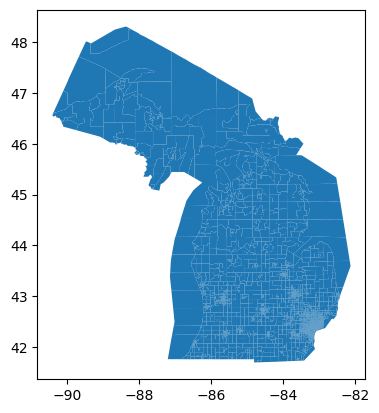

In [23]:
gdf_tracts.plot()

Remove weighted 'wt' suffix

In [24]:
gdf_tracts.columns = [col.replace("_wt", "") for col in gdf_tracts.columns]

<Axes: >

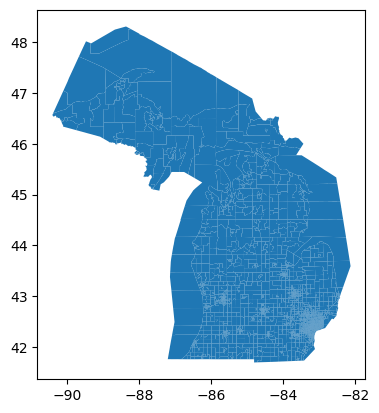

In [25]:
gdf_rates_demographics_merged = gdf_tracts.merge(
    df_processed_table,
    left_on="geo_id",
    right_on="geography_factor_id",
    how="right",
    validate="1:1",
)
# some missing tracts
gdf_rates_demographics_merged.plot()

## Detroit filter

<Axes: >

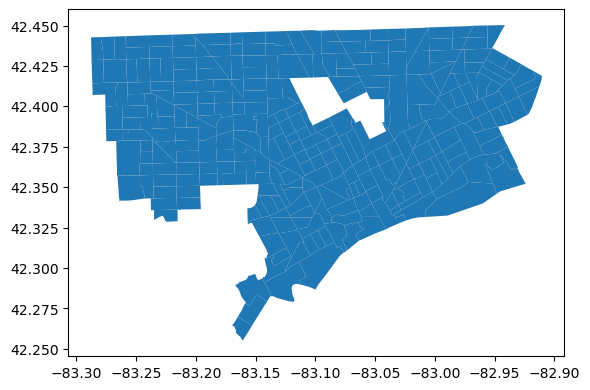

In [26]:
gdf_rates_demographics_merged["is_in_detroit"] = gdf_rates_demographics_merged[
    "geo_id"
].isin(list(DF_DETROIT_TRACTS["geoid_10"]))
gdf_rates_demographics_merged[gdf_rates_demographics_merged["is_in_detroit"]].plot()

## 8 Mile Road

In [27]:
GDF_STREETS = gpd.read_file(DETROIT_STREETS)
GDF_STREETS

,FID,RDNAME,Type,Shape__Len,Shape__L_1,Shape_Leng,Shape__L_2,Shape_Le_1,Shape_Le_2,geometry
0,1,8 Mile Rd,MDOT,19.172881,30855.822722,0.0,0.0,41753.788750,41753.788750,"MULTILINESTRING ((-9271553.293 5227502.008, -9..."
1,2,Belle Isle,MDOT,0.000000,0.000000,0.0,0.0,34373.308201,34373.308201,"MULTILINESTRING ((-9239330.499 5211052.758, -9..."
2,3,E Davison St,MDOT,0.000000,0.000000,0.0,0.0,4619.825696,4619.825696,"MULTILINESTRING ((-9248127.272 5222498.142, -9..."
3,4,E Jefferson Ave,MDOT,0.000000,0.000000,0.0,0.0,1667.870198,1667.870198,"MULTILINESTRING ((-9244465.807 5210319.667, -9..."
4,6,Fort St,MDOT,0.000000,0.000000,0.0,0.0,656.713537,656.713537,"LINESTRING (-9256933.078 5202210.539, -9256855..."
...,...,...,...,...,...,...,...,...,...,...
29729,29893,Ford Rd,MDOT,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-9263565.162 5210409.198, -9264586..."
29730,29894,Wyoming St,County,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-9256982.570 5211583.836, -9256965..."
29731,29895,Margareta St,City Minor,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-9269685.351 5224933.985, -9269639..."
29732,29896,St Aubin,City Major,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-9245802.270 5218424.497, -9245965..."


### Filter and buffer 8 mile drive

In [28]:
gdf_roads_8_mile = GDF_STREETS[GDF_STREETS["RDNAME"].isin(ROADS_TO_FILTER)].copy()
gdf_roads_8_mile_buffered = gdf_roads_8_mile.copy()
gdf_roads_8_mile_buffered["geometry"] = gdf_roads_8_mile_buffered["geometry"].buffer(
    MILE_BUFFER
)
gdf_roads_8_mile_buffered

,FID,RDNAME,Type,Shape__Len,Shape__L_1,Shape_Leng,Shape__L_2,Shape_Le_1,Shape_Le_2,geometry
0,1,8 Mile Rd,MDOT,19.172881,30855.822722,0.0,0.0,41753.78875,41753.78875,"POLYGON ((-9271637.297 5230697.376, -9271637.3..."


### Filter for rates near 8 mile drive

<Axes: >

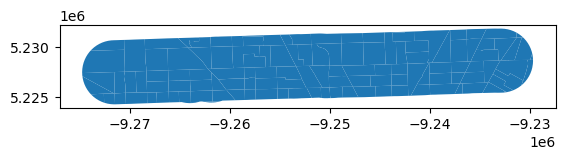

In [29]:
gdf_8_mile_rates = gpd.overlay(
    gdf_rates_demographics_merged.to_crs(gdf_roads_8_mile_buffered.crs),
    gdf_roads_8_mile_buffered,
)
gdf_8_mile_rates.plot()

In [30]:
gdf_rates_demographics_merged["is_along_8_mile"] = gdf_rates_demographics_merged[
    "geography_factor_id"
].isin(gdf_8_mile_rates["geography_factor_id"])

In [31]:
EIGHT_MILE_LAT = 42.45
gdf_rates_demographics_merged["is_south_8_mile"] = (
    gdf_rates_demographics_merged["geometry"].bounds["maxy"] < EIGHT_MILE_LAT
) & gdf_rates_demographics_merged["is_along_8_mile"]
gdf_rates_demographics_merged["is_north_8_mile"] = (
    ~(gdf_rates_demographics_merged["is_south_8_mile"])
    & gdf_rates_demographics_merged["is_along_8_mile"]
)

<Axes: >

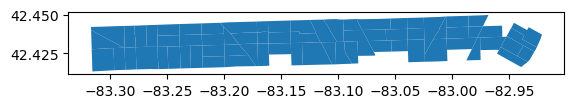

In [32]:
gdf_rates_demographics_merged[gdf_rates_demographics_merged["is_south_8_mile"]].plot()

<Axes: >

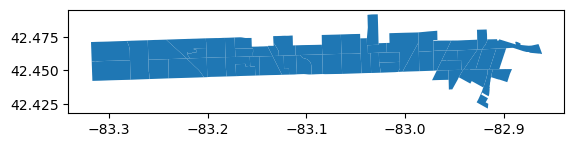

In [33]:
gdf_rates_demographics_merged[gdf_rates_demographics_merged["is_north_8_mile"]].plot()

The road has a slight positive slope, so a few tracts fall below the general latitude bound chosen for the filter. I have picked out the mislabeled tracts and ƒix below.

In [34]:
TRACTS_MISLABELED_NORTH = [
    "26163551300",
    "26163551400",
    "26163551800",
    "26163500100",
    "26163500200",
]
gdf_rates_demographics_merged["is_south_8_mile"] = (
    gdf_rates_demographics_merged["is_south_8_mile"]
) | (gdf_rates_demographics_merged["geo_id"].isin(TRACTS_MISLABELED_NORTH))

# Export

In [35]:
expected_col_order = BASE_COLUMNS + rate_col_names
df_export = df_processed_table[expected_col_order]
df_export.to_csv(PROCESSED_EXPORT_FP, index=False)
df_export

,company,vehicle_type,factor_circumvented,factor_name,geography_factor,geography_type,geography_factor_id,latitude,longitude,county_fips,...,rate_mlpd,rate_ppi,rate_pip_med,rate_pip_wl,rate_comp,rate_coll,rate_cr,rate_um_uim,generic_location_based_premium,location_effect
0,Auto Club,Auto,zip,Base Rate,census_tract,census_tract,26001000100,None,None,None,...,34.241984,69.113952,3519.562940,142.439048,242.353224,985.649836,46.977600,63.369230,5477.0,0.74
1,Auto Club,Auto,zip,Base Rate,census_tract,census_tract,26001970100,None,None,None,...,34.265896,69.113952,3526.116044,142.545904,242.353224,985.446693,46.977600,63.369230,5483.0,0.74
2,Auto Club,Auto,zip,Base Rate,census_tract,census_tract,26001970400,None,None,None,...,34.265896,69.113952,3526.116044,142.545904,242.353224,985.446693,46.977600,63.369230,5483.0,0.74
3,Auto Club,Auto,zip,Base Rate,census_tract,census_tract,26001970500,None,None,None,...,34.636532,69.757728,3546.321448,144.709738,242.939592,1002.104419,47.917152,64.001706,5530.0,0.74
4,Auto Club,Auto,zip,Base Rate,census_tract,census_tract,26001970600,None,None,None,...,34.265896,69.113952,3526.116044,142.545904,242.353224,985.446693,46.977600,63.369230,5483.0,0.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2810,Auto Club,Auto,zip,Base Rate,census_tract,census_tract,26105990000,None,None,None,...,35.090860,69.113952,3611.306396,142.545904,242.353224,1058.375030,46.977600,63.369230,5651.0,0.76
2811,Auto Club,Auto,zip,Base Rate,census_tract,census_tract,26101990000,None,None,None,...,35.090860,69.113952,3611.306396,142.545904,242.353224,1058.375030,46.977600,63.369230,5651.0,0.76
2812,Auto Club,Auto,zip,Base Rate,census_tract,census_tract,26029990000,None,None,None,...,44.302958,87.817944,3792.062848,181.281204,249.866064,1374.262395,60.053032,81.042069,6353.0,0.86
2813,Auto Club,Auto,zip,Base Rate,census_tract,census_tract,26161421900,None,None,None,...,51.488514,78.345240,4078.215056,199.820720,291.644784,1418.547569,62.225746,93.059113,6834.0,0.92


In [36]:
# export direct extraction
DF_TERRITORY_RELATIVES.to_csv(RAW_EXPORT_FP, index=False)

In [37]:
gdf_rates_demographics_merged[CLEAN_EXPORT_COLS].to_csv(CLEAN_EXPORT_FP, index=False)
gdf_rates_demographics_merged[CLEAN_EXPORT_COLS + ["geometry"]].to_file(
    CLEAN_MAP_EXPORT_FP, driver="GeoJSON"
)

In [38]:
gdf_rates_demographics_merged.to_file(GIS_EXPORT_FP, driver="GeoJSON")
gdf_rates_demographics_merged

,geo_id,geo_name,tot_pop,white_tot,black_tot,aian_tot,asian_tot,nhopi_tot,other_tot,two_more_tot,...,longitude,latitude,zip,block_group_fips,place_name_fips,county_fips,is_in_detroit,is_along_8_mile,is_south_8_mile,is_north_8_mile
0,26001000100,Census Tract 1,1667.0,1550.0,8.0,0.0,0.0,0.0,17.0,57.0,...,None,None,None,None,None,None,False,False,False,False
1,26001970100,Census Tract 9701,2437.0,2263.0,9.0,11.0,20.0,0.0,5.0,63.0,...,None,None,None,None,None,None,False,False,False,False
2,26001970400,Census Tract 9704,2789.0,2661.0,20.0,17.0,0.0,2.0,4.0,54.0,...,None,None,None,None,None,None,False,False,False,False
3,26001970500,Census Tract 9705,2057.0,1907.0,3.0,1.0,12.0,0.0,0.0,93.0,...,None,None,None,None,None,None,False,False,False,False
4,26001970600,Census Tract 9706,1288.0,1222.0,4.0,2.0,0.0,0.0,0.0,44.0,...,None,None,None,None,None,None,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2808,26105990000,Census Tract 9900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,None,None,None,None,None,None,False,False,False,False
2809,26101990000,Census Tract 9900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,None,None,None,None,None,None,False,False,False,False
2810,26029990000,Census Tract 9900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,None,None,None,None,None,None,False,False,False,False
2811,26161421900,Census Tract 4219,1555.0,609.0,751.0,11.0,20.0,0.0,0.0,0.0,...,None,None,None,None,None,None,False,False,False,False


# Appendix

- Quick verification that all tract IDs equal expected length
- For more on GEOID lengths read [Understanding Geographic Identifiers (GEOIDs)](https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html)


In [39]:
assert (DF_TERRITORY_RELATIVES["Census Tract"].apply(len) == TRACT_GEO_ID_LEN).all()